In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
from timevqvae.generation import TrainedModelSampler
from timevqvae.utils import get_data, load_yaml_param_settings, set_seed
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
sns.set(style="whitegrid")

In [2]:
config="../configs/config.yaml"
dataset_file = "../data/real/OpenSky_EHAM_LIMC.pkl"
model_save_dir = "../saved_models"
route = "EHAM_LIMC"
use_fidelity_enhancer=True

config = load_yaml_param_settings(config)
config["dataset"]["file"] = dataset_file
config["logger"]["model_save_dir"] = model_save_dir


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the numpy matrix of the test samples
features = config["dataset"]["features"]
batch_size = config["evaluation"]["batch_size"]

train_data_loader, test_data_loader, scalar = get_data(
    dataset_file, features, batch_size
)
X_train, X_test, Y_train, Y_test = (
    train_data_loader.dataset.X.numpy(),
    test_data_loader.dataset.X.numpy(),
    train_data_loader.dataset.Y,
    test_data_loader.dataset.Y,
)
n_classes = len(np.unique(Y_train))
_, in_channels, input_length = X_train.shape


n_test_samples_per_class = dict(Counter(test_data_loader.dataset.Y.flatten()))


seed = 73
set_seed(seed)

dataset_name = os.path.basename(config["dataset"]["file"]).split(".")[0]
stage1_ckpt_fname = os.path.join(model_save_dir, dataset_name, "stage1.ckpt")
stage2_ckpt_fname = os.path.join(model_save_dir, dataset_name, "stage2.ckpt")
stage3_ckpt_fname = os.path.join(model_save_dir, dataset_name, "stage3.ckpt")
fcn_ckpt_fname = os.path.join(model_save_dir, dataset_name, "fcn.ckpt")


In [3]:
evaluation = TrainedModelSampler(
    stage1_ckpt_fname=stage1_ckpt_fname,
    stage2_ckpt_fname=stage2_ckpt_fname,
    stage3_ckpt_fname=stage3_ckpt_fname,
    fcn_ckpt_fname=fcn_ckpt_fname,
    input_length=input_length,
    in_channels=in_channels,
    n_classes=n_classes,
    batch_size=batch_size,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    device=device,
    config=config,
    use_fidelity_enhancer=use_fidelity_enhancer,
    feature_extractor_type=config["evaluation"]["feature_extractor_type"],
    do_evaluate=True,
).to(device)

X_gen, X_gen_R, Y_gen = [], [], []
for class_idx, n_samples in n_test_samples_per_class.items():
    # print(f"sampling synthetic data | class_idx: {class_idx}...")
    (_, _, xhat_tmp), xhat_R_tmp = evaluation.sample(
        n_samples=n_samples, kind="conditional", class_index=class_idx
    )
    X_gen.append(xhat_tmp)
    X_gen_R.append(xhat_R_tmp)
    Y_gen.append(torch.Tensor([class_idx] * n_samples))
X_gen = torch.cat(X_gen).float()  # (b c l)
X_gen_R = torch.cat(X_gen_R).float()  # (b c l)
Y_gen = torch.cat(Y_gen)[:, None].long()  # (b 1)
print("X_gen.shape:", X_gen.shape)
print("X_gen_R.shape:", X_gen_R.shape)
print("Y_gen.shape:", Y_gen.shape)


X_gen.shape: torch.Size([660, 4, 4633])
X_gen_R.shape: torch.Size([660, 4, 4633])
Y_gen.shape: torch.Size([660, 1])


In [4]:
z_train = evaluation.z_train
z_test = evaluation.z_test
z_rec_train = evaluation.compute_z_rec("train")
z_rec_test = evaluation.compute_z_rec("test")
zhat = evaluation.compute_z_gen(X_gen)
z_svq_train, x_prime_train = evaluation.compute_z_svq("train")
z_svq_test, x_prime_test = evaluation.compute_z_svq("test")
zhat_R = evaluation.compute_z_gen(X_gen_R)

In [5]:
# shape
print(f"z_train.shape: {z_train.shape}, z_test.shape: {z_test.shape}")
print(f"z_rec_train.shape: {z_rec_train.shape}, z_rec_test.shape: {z_rec_test.shape}")
print(f"zhat.shape: {zhat.shape}")
print(f"z_svq_train.shape: {z_svq_train.shape}, x_prime_train.shape: {x_prime_train.shape}")
print(f"z_svq_test.shape: {z_svq_test.shape}, x_prime_test.shape: {x_prime_test.shape}")
print(f"zhat_R.shape: {zhat_R.shape}")

z_train.shape: (5932, 2000), z_test.shape: (660, 2000)
z_rec_train.shape: (5932, 2000), z_rec_test.shape: (660, 2000)
zhat.shape: (660, 2000)
z_svq_train.shape: (5932, 2000), x_prime_train.shape: (5932, 4, 4633)
z_svq_test.shape: (660, 2000), x_prime_test.shape: (660, 4, 4633)
zhat_R.shape: (660, 2000)


In [6]:
FID = evaluation.fid_score(z_test, zhat)
FID_R = evaluation.fid_score(z_test, zhat_R)
print(f"FID: {FID:.4f}, FID with fidelity enhancer: {FID_R:.4f}")

IS_mean, IS_std = evaluation.inception_score(X_gen)
print(f"IS_mean: {IS_mean:.4f}, IS_std: {IS_std:.4f}")
print(f"IS: {IS_mean:.4f} +/- {IS_std:.4f}")

IS_mean_R, IS_std_R = evaluation.inception_score(X_gen_R)
print(f"IS_mean with fidelity enhancer: {IS_mean_R:.4f}, IS_std with fidelity enhancer: {IS_std_R:.4f}")
print(f"IS with fidelity enhancer: {IS_mean_R:.4f} +/- {IS_std_R:.4f}")

mdd, acd, sd, kd = evaluation.stat_metrics(evaluation.X_test, X_gen)
print(f"mdd: {mdd:.4f}, acd: {acd:.4f}, sd: {sd:.4f}, kd: {kd:.4f}")


mdd_R, acd_R, sd_R, kd_R = evaluation.stat_metrics(evaluation.X_test, X_gen_R)
print(f"mdd with fidelity enhancer: {mdd_R:.4f}, acd with fidelity enhancer: {acd_R:.4f}, sd with fidelity enhancer: {sd_R:.4f}, kd with fidelity enhancer: {kd_R:.4f}")

FID: 0.0035, FID with fidelity enhancer: 0.0099
IS_mean: 3.4049, IS_std: 0.2660
IS: 3.4049 +/- 0.2660
IS_mean with fidelity enhancer: 3.4331, IS_std with fidelity enhancer: 0.2396
IS with fidelity enhancer: 3.4331 +/- 0.2396
mdd: 0.0512, acd: 5.6334, sd: 0.0554, kd: 0.1065
mdd with fidelity enhancer: 0.0359, acd with fidelity enhancer: 7.8916, sd with fidelity enhancer: 0.0294, kd with fidelity enhancer: 0.0657


## Quality Metrics

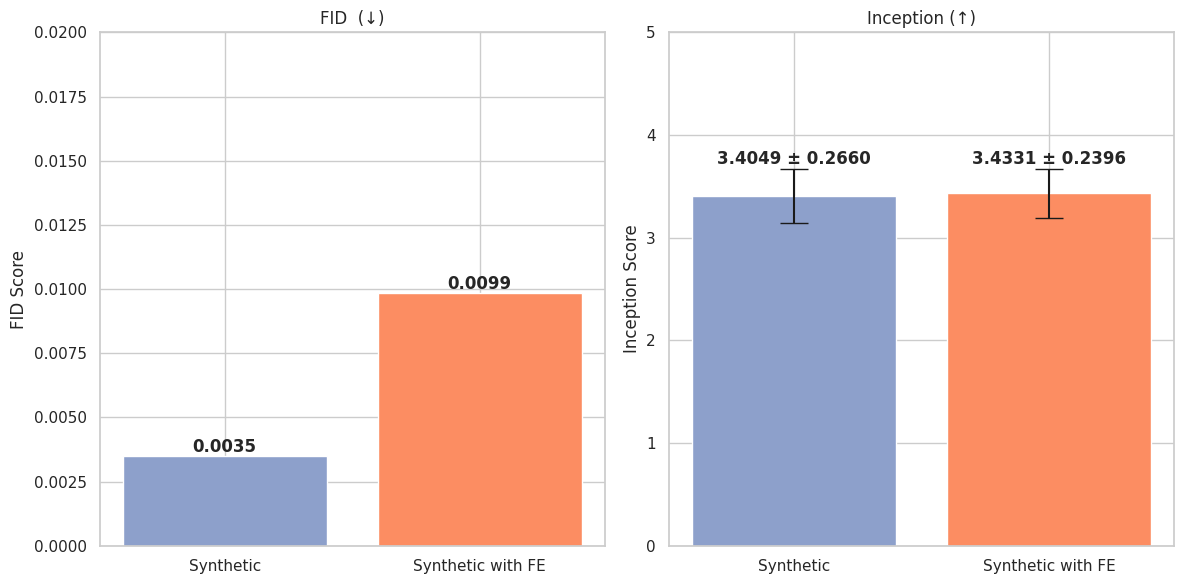

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

color_without_FE = "#8da0cb"  # Cool lavender
color_with_FE = "#fc8d62"     # Soft coral


# Bar plot for FID scores
bars1 = ax[0].bar(['Synthetic', 'Synthetic with FE'], [FID, FID_R], color=[color_without_FE, color_with_FE])
ax[0].set_ylabel('FID Score')
ax[0].set_title('FID  (↓)')  # Arrow indicates lower is better
ax[0].set_ylim(0, 0.02)  # 

# Add FID values above the bars
for bar in bars1:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12, fontweight='bold')

# Error bar plot for Inception Scores
bars2 = ax[1].bar(['Synthetic', 'Synthetic with FE'], [IS_mean, IS_mean_R], yerr=[IS_std, IS_std_R], capsize=10, color=[color_without_FE, color_with_FE])
ax[1].set_ylabel('Inception Score')
ax[1].set_title('Inception (↑)')  # Arrow indicates higher is better
ax[1].set_ylim(0, 5)  # Set the y-axis limit to 4

# Add IS values above the bars in the format IS_mean ± IS_std
for i, bar in enumerate(bars2):
    yval = bar.get_height()
    if i == 0:
        ax[1].text(bar.get_x() + bar.get_width()/2.0, yval + IS_std + 0.01, f'{IS_mean:.4f} ± {IS_std:.4f}', 
                   va='bottom', ha='center', fontsize=12, fontweight='bold')
    else:
        ax[1].text(bar.get_x() + bar.get_width()/2.0, yval + IS_std_R + 0.01, f'{IS_mean_R:.4f} ± {IS_std_R:.4f}', 
                   va='bottom', ha='center', fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()


plt.savefig(f"../.figures/fid_is_{route}.png", bbox_inches='tight')
plt.show()

## Statistical Metrics

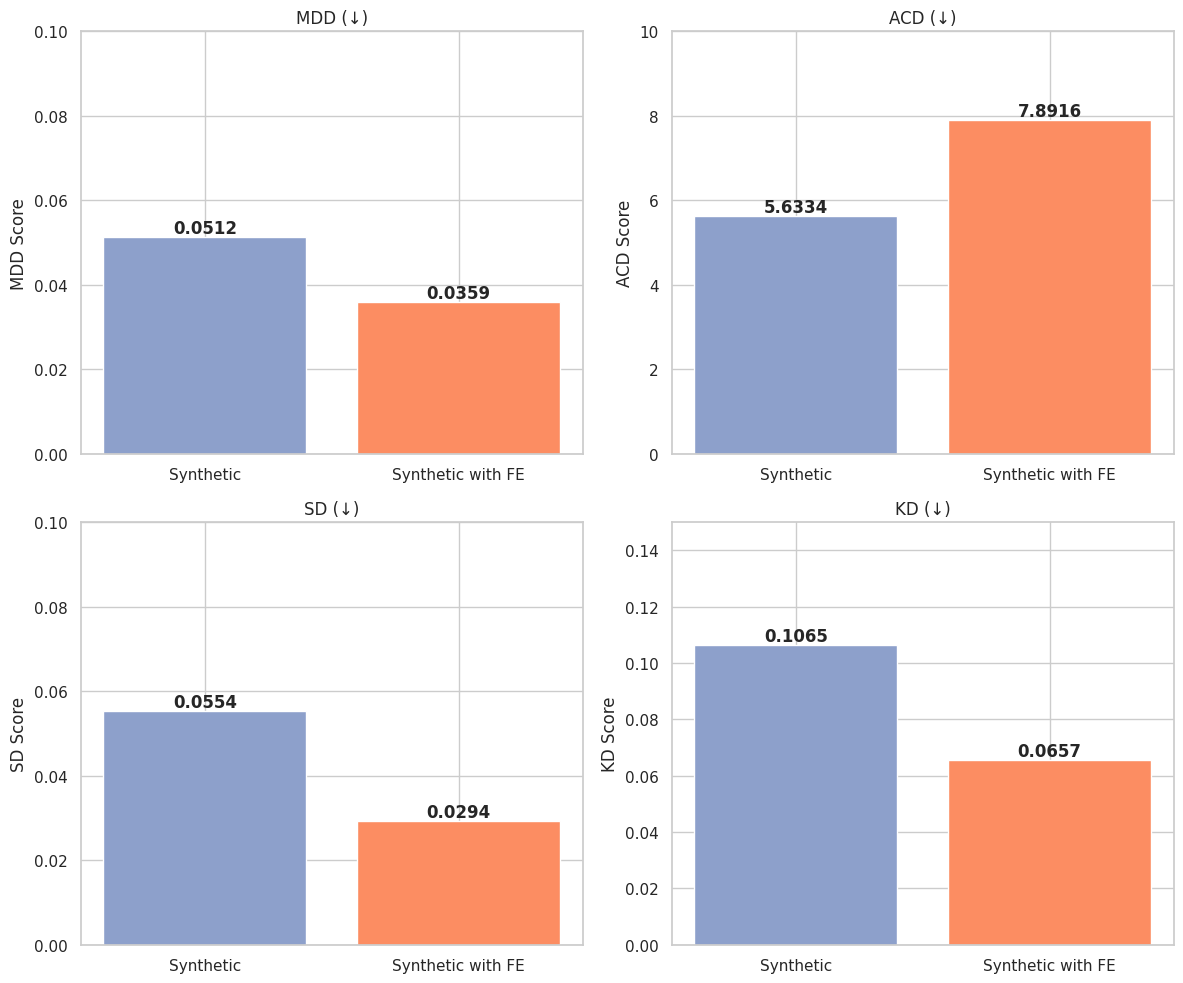

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

color_without_FE = "#8da0cb"  # Cool lavender
color_with_FE = "#fc8d62"     # Soft coral


# MDD plot
bars1 = ax[0, 0].bar(['Synthetic', 'Synthetic with FE'], [mdd, mdd_R], color=[color_without_FE, color_with_FE])
ax[0, 0].set_ylabel('MDD Score')
ax[0, 0].set_title('MDD (↓)')
ax[0, 0].set_ylim(0, 0.1)

for bar in bars1:
    yval = bar.get_height()
    ax[0, 0].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12, fontweight='bold')

# ACD plot
bars2 = ax[0, 1].bar(['Synthetic', 'Synthetic with FE'], [acd, acd_R], color=[color_without_FE, color_with_FE])
ax[0, 1].set_ylabel('ACD Score')
ax[0, 1].set_title('ACD (↓)')
ax[0, 1].set_ylim(0, 10)

for bar in bars2:
    yval = bar.get_height()
    ax[0, 1].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12, fontweight='bold')

# SD plot
bars3 = ax[1, 0].bar(['Synthetic', 'Synthetic with FE'], [sd, sd_R], color=[color_without_FE, color_with_FE])
ax[1, 0].set_ylabel('SD Score')
ax[1, 0].set_title('SD (↓)')
ax[1, 0].set_ylim(0, 0.1)

for bar in bars3:
    yval = bar.get_height()
    ax[1, 0].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12, fontweight='bold')

# KD plot
bars4 = ax[1, 1].bar(['Synthetic', 'Synthetic with FE'], [kd, kd_R], color=[color_without_FE, color_with_FE])
ax[1, 1].set_ylabel('KD Score')
ax[1, 1].set_title('KD (↓)')
ax[1, 1].set_ylim(0, 0.15)

for bar in bars4:
    yval = bar.get_height()
    ax[1, 1].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()


plt.savefig(f"../.figures/stat_metrics_{route}.png", bbox_inches='tight')
plt.show()